# Project 02 - Due Friday, November 11 at 12pm

*Objectives*: Gain experience loading a transactional dataset into a relational database model you define yourself and using SQL to explore its contents. Transform the data into a star schema, documenting the schema visually, and explore the transformed data analytically by writing and executing a number of SQL queries using common syntax and functions and describing your findings.  Gain practice working on these tasks with a partner.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries, diagrams, and charts in the space provided, unless a text answer is requested.  The notebook itself should be completely reproducible at datanotebook.org, from start to finish: another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

*Attestation*: **Work in pairs**.  At the end of your submitted notebook, identify the work each partner performed and attest that each contributed substantially to the work.

*Deadline*: Friday, November 11, 12pm.  One member of each pair must submit your notebook to Blackboard; you should not both submit it separately.  You may each push a copy to your own GitHub repository.


## Setup - select and obtain data

The US City Open Data Census has a variety of [transactional data from all over the country](http://us-city.census.okfn.org/).  Select one topic and one city from this Census, download the data, and explain your reason for this choice before proceeding.  Provide a link to the web page for the data set you've chosen.

I strongly encourage you to select a dataset from among the following topics:  Crime, Property Assessment, Campaign Finance Contributions, Service Requests (311), and Web Analytics.

By *transactional* data I mean records at the grain of one event per business process.  In the case of Service Requests (311), for example, that would require data at the level of each individual report of a service request.  If this isn't clear, think about the bike trip data - each individual ride was included - and look for data at that level of event/process specificity.  Avoid data like the Connecticut boating data, which was summarized by year, not individual transactions.

Please aim for a dataset of at least 10,000 individual records, but less than 250,000 records.  A little more or a little less is okay, but try to stay within these limits.

### Santa Monica Sevice Requested Dataset
https://data.smgov.net/Public-Services/Closed-GovOutreach-Submissions/tsas-mvez
It is a nice transactional dataset. It has 58268 records, meeting the size requirement. Futhermore, the Santa Monica website provides a nice API for exporting the dataset in a csv format. There at least two dimensions in this dataset, location and time. The "Days to Respond" column is a measurement column in this dataset.



In [16]:
!wget https://data.smgov.net/api/views/tsas-mvez/rows.csv?accessType=DOWNLOAD -O service.csv

--2016-11-10 01:03:11--  https://data.smgov.net/api/views/tsas-mvez/rows.csv?accessType=DOWNLOAD
Resolving data.smgov.net (data.smgov.net)... 52.206.140.199
Connecting to data.smgov.net (data.smgov.net)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘service.csv’

service.csv             [                  <=> ]   5.74M  1.55MB/s   in 3.7s   

Last-modified header invalid -- time-stamp ignored.
2016-11-10 01:03:15 (1.54 MB/s) - ‘service.csv’ saved [6018815]



## Problem 1 - examine the data (20 points)

Use `csvstat`, `pandas`, or other tools as you see fit and observe the contents of your dataset.  Review important points from any metadata provided.  Describe what you see:  What do the columns mean?  Are there null values?  Which columns interest you the most?  Which columns present some opportunities, challenges, or questions you would like to ask?

In [17]:
!head -n2 service.csv

Request ID,Topic,Assigned Department,Status,Request Date,Response Date,Days to Respond,Latitude,Longitude,Location
1988340,Parking & Traffic Enforcement Issues,Police,Closed,12/10/2014,12/17/2014,6,,,


In [18]:
!pip install gmplot

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import sqlalchemy as sq
import seaborn as sns
from matplotlib import pyplot as plt
import gmplot
sns.set()
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [20]:
df = pd.read_csv('service.csv', parse_dates=['Request Date', 'Response Date'])

In [21]:
df.shape

(58563, 10)

#### What do the columns mean?

The first two columns represent information about the requests, while the last two denote the specific location of the subject requests. The remaining columns keep track of filing and responding date/status update.

In [22]:
df.dtypes

Request ID                      int64
Topic                          object
Assigned Department            object
Status                         object
Request Date           datetime64[ns]
Response Date          datetime64[ns]
Days to Respond               float64
Latitude                      float64
Longitude                     float64
Location                       object
dtype: object

The column names are self-explanatory.

#### Are there null values?

As can be seen from the output, there are six columns that have null values. 

In [23]:
df.isnull().sum()

Request ID                 0
Topic                      0
Assigned Department      697
Status                     0
Request Date               0
Response Date              3
Days to Respond            3
Latitude               30892
Longitude              30892
Location               30892
dtype: int64

In [24]:
## replace null values wiht unknown
df.ix[df['Assigned Department'].isnull(), 'Assigned Department']= 'unknown'
df.ix[df['Location'].isnull(), 'Location']= 'unknown'

#### Which columns interest you the most?

Topic, Assigned Department and Days to Respond columns are the most interesting ones to me. Analysis performed on thoese columns can reveal how effeciently each department handles their service requests. The average and total number of days it takes to resolve the requests would be good indicators of such efficiency measures.

#### Which columns present some opportunities, challenges, or questions you would like to ask?

Latitude and Longitude have a lot of missing values. While is possible that the location data are not directly relevant for many services, even without missing values it could be hard to find free service to convert latitudes and longitudes to addresses that can enrich the location dimension. Lastly, the service column may post some challenges as well since a service request can be handled by multiple departments, therefore making it more difficult to truly assess how efficiently the request was handled and by which department. 

## Problem 2 - define a database model, load the data, and explore (20 points)

Based on what you found above, create and connect to a new database, define a database table in it, and load this dataset into it.  You may use either of the methods for this step you have seen in earlier class notebooks.  You may choose to eliminate variables/columns if they are not relevant or interesting to you - explain your reasoning if you do.  Either way, you should load a majority of the columns present in the source dataset as it is in its raw form into the database, and all of its rows.

Once your data has loaded successfully, run a `COUNT(*)` query to verify that all the data has loaded correctly.

Explore the data to zero in on a few themes you would like to further study analytically.  Discuss columns that present opportunities for extraction into dimensions, and identify the specific columns that contain facts you want to measure.

In [25]:
!echo 'redspot' | sudo -S service postgresql restart
!createdb -U dbuser prj2

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.
createdb: database creation failed: ERROR:  database "prj2" already exists


In [26]:
%sql postgresql://dbuser@localhost:5432/prj2

'Connected: dbuser@prj2'

In [27]:
!pwd

/home/jovyan/work


In [28]:
%%sql
DROP TABLE IF EXISTS service;
Create Table service(
    request_id integer,
    topic varchar(50),
    assigned_department varchar(50),
    status varchar(50),
    request_date date,
    response_date date,
    days_to_respond real,
    latitude float8,
    longitude float8,
    Location varchar(100),
    primary key(request_id)
);

(psycopg2.OperationalError) terminating connection due to administrator command
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
 [SQL: 'DROP TABLE IF EXISTS service;']


In [29]:
df.to_csv('tosql.csv', index=False)

In [30]:
%%sql
COPY service FROM '/home/jovyan/work/tosql.csv'
CSV
HEADER
DELIMITER ',';

58563 rows affected.


[]

In [31]:
%%sql
Select Count(*)
From service;

1 rows affected.


count
58563


## Problem 3 - define a star schema, and load your data into it (30 points)

Define a star schema consisting of at least one fact table and at least two dimensions.  Transform your source data into the new fact table and dimensions.  Discuss your key modeling decisions.

Document your star schema with a diagram.  There several tools available for this, such as Google Docs and Microsoft Visio.

#### Star Schema Diagram
     Note: The prj2_star.png has to uploaded to datanotebook.org too.

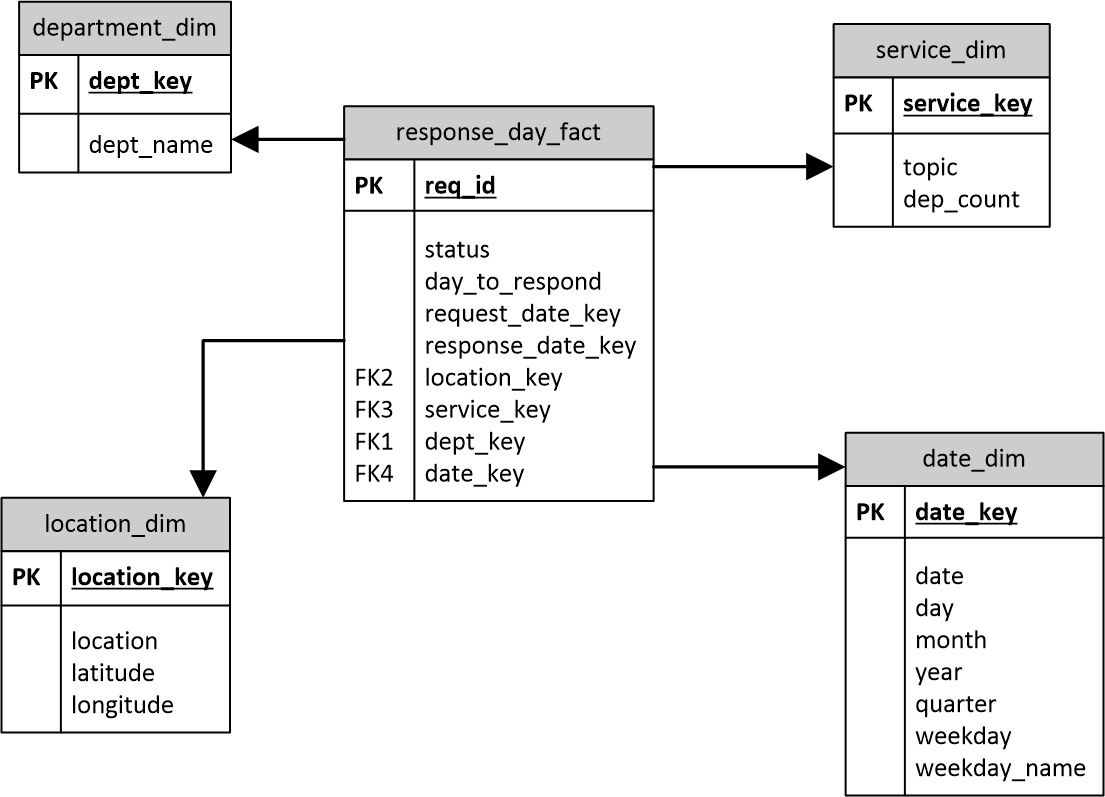

In [32]:
from IPython.display import Image
Image('prj2_star.png')

## Getting the date range before creating the date dimension table

In [33]:
#check date range
print('Min of Request Date: {0}'.format(df['Request Date'].min()))
print('Max of Request Date: {0}'.format(df['Request Date'].max()))
print('Min of Response Date: {0}'.format(df['Response Date'].min()))
print('Max of Response Date: {0}'.format(df['Request Date'].max()))

Min of Request Date: 2005-05-16 00:00:00
Max of Request Date: 2016-11-08 00:00:00
Min of Response Date: 2005-12-12 00:00:00
Max of Response Date: 2016-11-08 00:00:00


In [34]:
dates = pd.date_range(start='2005-05-01', end='2016-12-31')
days = dates.day
months = dates.month
years = dates.year
qtrs = dates.quarter
weekdays = dates.weekday
weekday_names = dates.weekday_name
date_df = pd.DataFrame({
        'date': dates,
        'day' : days,
        'month': months,
        'year': years,
        'quarter': qtrs,
        'weekday': weekdays,
        'weekday_name': weekday_names
    })
date_df['date_key'] = date_df.index
date_df = date_df[['date_key', 'date', 'day', 'month', 'year','quarter','weekday','weekday_name']]
date_df.to_csv('date.csv', index=False)

In [35]:
%%sql
DROP TABLE IF EXISTS date_dim;
Create Table date_dim(
    date_key integer,
    date date,
    day smallint,
    month smallint,
    year smallint,
    quarter smallint,
    weekday smallint,
    weekday_name varchar(9),
    primary key(date_key)
);

Done.
Done.


[]

In [36]:
%%sql
COPY date_dim FROM '/home/jovyan/work/date.csv'
CSV
HEADER
DELIMITER ',';

4263 rows affected.


[]

In [37]:
#add dateky to the fact dataset
date_key_df =  date_df[['date_key', 'date']]
df_fact = df.merge(date_key_df, how='left', left_on='Request Date', right_on='date')
df_fact.rename(columns={'date_key': 'request_date_key'},inplace=True)
df_fact.drop(['Request Date', 'date'], axis=1, inplace=True)
df_fact = df_fact.merge(date_key_df, how='left', left_on='Response Date', right_on='date')
df_fact.rename(columns={'date_key': 'response_date_key'},inplace=True)
df_fact.drop(['Response Date', 'date'], axis=1, inplace=True)

In [38]:
df_fact.shape

(58563, 10)

##  Creates the location dimension table.

In [39]:
#check how many unique locations
locations = df_fact['Location'].unique()
locations.shape

(25730,)


We tried to use Google Maps Geocoding APi to reverse geocode latitude and longitude to enrich location dimension with address information. But the free service has the usage limit of 2500 queries.

In [40]:
df_locations = pd.DataFrame({'location': locations})
#drop nan 
df_locations.drop(0, inplace=True)
df_locations['temp'] = df_locations.location.str.replace('(','')
df_locations['temp'] = df_locations.temp.str.replace(')','')
df_locations['latitude'] = df_locations.temp.map(lambda x: float(x.split(',')[0]))
df_locations['longitude'] = df_locations.temp.map(lambda x: float(x.split(',')[1]))
df_locations.drop('temp', axis=1, inplace=True)
df_locations['location_key'] = df_locations.index
df_locations = df_locations[['location_key', 'location', 'latitude', 'longitude' ]]
df_locations.to_csv('locations.csv', index=False)

In [41]:
%%sql
DROP TABLE IF EXISTS location_dim;
Create Table location_dim(
    location_key integer,
    location varchar(250),
    latitude float8,
    longitude float8,
    primary key(location_key)
) ;

Done.
Done.


[]

In [42]:
%%sql
Copy location_dim From '/home/jovyan/work/locations.csv'
CSV 
Header 
DELIMITER ',';

25729 rows affected.


[]

In [43]:
## add locatin key to the orignal dataset
df_fact = df_fact.merge(df_locations, how='left', left_on='Location', right_on='location')
df_fact.drop(['Latitude', 'Longitude', 'Location', 'latitude', 'longitude', 'location'],
                          axis=1, inplace=True)

# Creates the service dimension table.

In [44]:
service_topics = df_fact['Topic'].unique() 
df_topics = pd.DataFrame({'topic': service_topics})

In [45]:
#feautre engineering
#find out that a service is handle by how many departments 
df_topic_dep = df[['Topic', 'Assigned Department']]
df_topic_dep.drop_duplicates(inplace=True)
df_topic_dep_gr = df_topic_dep.groupby('Topic')
df_topic_dep_count = df_topic_dep_gr.count().reset_index()
df_topics['service_key'] = df_topics.index
df_topics = df_topics.merge(df_topic_dep_count, left_on='topic', right_on='Topic')
df_topics = df_topics[['service_key', 'topic', 'Assigned Department']]
df_topics.columns = ['service_key', 'topic', 'dep_count']
df_topics.to_csv('topics.csv', index=False)

/opt/conda/lib/python3.5/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [46]:
%%sql
DROP TABLE IF EXISTS service_dim;
Create Table service_dim(
    service_key integer,
    topic varchar(250),
    dep_count integer,
    primary key(service_key)
)

Done.
Done.


[]

In [47]:
%%sql
Copy service_dim From '/home/jovyan/work/topics.csv'
CSV 
Header 
DELIMITER ',';

173 rows affected.


[]

In [48]:
#add service key to fact dataset
df_fact = df_fact.merge(df_topics, how='left', left_on="Topic", right_on="topic")
df_fact.drop(['Topic', 'topic', 'dep_count'], axis=1, inplace=True)

## Creates the department dimension table.

In [49]:
departments = df_fact['Assigned Department'].unique()
departments.shape

(19,)

In [50]:
df_dept = pd.DataFrame({'department': departments})
df_dept.dropna(inplace=True)

In [51]:
df_dept['dept_key'] = df_dept.index

In [52]:
df_dept = df_dept[['dept_key', 'department']]

In [53]:
df_dept.to_csv('dept.csv', index=False)

In [54]:
%%sql
DROP TABLE IF EXISTS department_dim;
Create Table department_dim(
    dept_key integer,
    dept_name varchar(50),
    primary key(dept_key)
)

Done.
Done.


[]

In [55]:
%%sql
Copy department_dim From '/home/jovyan/work/dept.csv'
CSV 
Header 
DELIMITER ',';

19 rows affected.


[]

In [56]:
#add departmetn key to fact dataset
df_fact = df_fact.merge(df_dept, how='left', left_on="Assigned Department", right_on="department")
df_fact.drop(['Assigned Department', 'department'], axis=1, inplace=True)

# Creates the fact table

In [57]:
%%sql
DROP TABLE IF EXISTS response_day_fact;
Create Table response_day_fact(
    req_id integer,
    status varchar(15),
    day_to_respond real,
    request_date_key integer,
    response_date_key integer,
    location_key integer,
    service_key integer,
    dept_key integer,
    Primary Key(req_id),
    CONSTRAINT fk_req_date Foreign Key(request_date_key) REFERENCES date_dim(date_key),
    CONSTRAINT fk_res_date Foreign Key(response_date_key) REFERENCES date_dim(date_key),
    CONSTRAINT fk_location Foreign Key(location_key) REFERENCES location_dim(location_key),
    CONSTRAINT fk_service Foreign Key(service_key) REFERENCES service_dim(service_key),
    CONSTRAINT fk_department Foreign Key(dept_key) REFERENCES department_dim(dept_key)
)

Done.
Done.


[]

In [58]:
df_fact.to_csv('fact.csv', index=False)
df_fact.columns = ['req_id', 'status', 'day_to_respond', 'request_date_key', 'response_date_key',
                  'location_key', 'service_key','dept_key'] 

In [59]:
engine = sq.create_engine("postgresql+psycopg2://dbuser@localhost:5432/prj2")

In [60]:
df_fact.to_sql('response_day_fact', engine, if_exists='append', index=False)

In [61]:
%%sql
Select Count(*) 
From response_day_fact; 

1 rows affected.


count
58563


In [62]:
%%sql 
Select * 
From response_day_fact 
Limit 5;

5 rows affected.


req_id,status,day_to_respond,request_date_key,response_date_key,location_key,service_key,dept_key
1988340,Closed,6.0,3510,3517,None,0,0
1993315,Closed,3.0,3515,3517,None,1,1
2922837,Closed,13.0,4189,4205,None,2,2
2863817,Closed,11.0,4147,4161,None,3,0
1355037,Closed,2.0,2969,2970,None,4,0


## Problem 4 - explore your data in its new schema (30 points)

Strictly using the dimensional model tables you defined and populated for Problem 3, explore your data in its new form.  Use any of the query strategies we've seen in class, including transformations, aggregates, subqueries, rollups, and, of course, joins.  Add plots to highlight particular themes that stand out.  Describe your thinking and observations along the way.

#### Check if "day_to_respond" includes weekend.  
    Please Note: We created date_key in an ascending order so that we can substract request_date_key from response_date_key to find out durations.

In [63]:
sql = '''
Select day_to_respond , (response_date_key - request_date_key + 1) as days 
From response_day_fact as l inner join date_dim  as r 
On l.request_date_key=r.date_key 
Where r.weekday=4;
'''
df_days = pd.read_sql(sql, engine)
df_days.head(5)

,day_to_respond,days
0,12.0,18.0
1,29.0,41.0
2,2.0,4.0
3,3.0,5.0
4,12.0,18.0


Good! The "day_to_respond" column does not include weekends.

### Guiding Question 1
### How efficent, in terms of days, the Santa Monica government serve those requests?

Checking for requests that are not yet closed. The result shows that all requests were closed.

In [64]:
%%sql
Select count(*)
From response_day_fact 
Where Status <> 'Closed';

1 rows affected.


count
0


##### how many request took more than 30, 90, and 180 days to close?

In [65]:
sql = '''Select count(*) as closed_count
        From response_day_fact 
        Where day_to_respond > 30
        Union All
        Select count(*) as closed_count
        From response_day_fact 
        Where day_to_respond > 90
        Union All
        Select count(*) as closed_count
        From response_day_fact 
        Where day_to_respond > 180
        ;
'''
df_closed_count = pd.read_sql(sql, engine)
df_closed_count.index = [30, 90, 180]
df_closed_count

,closed_count
30,1656
90,488
180,142


There are 1655, 488, 142 service requests that took more than 30, 90, 180 days to be closed, respectively.

##### What are the department handling those requests that took 30 days to be closed?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

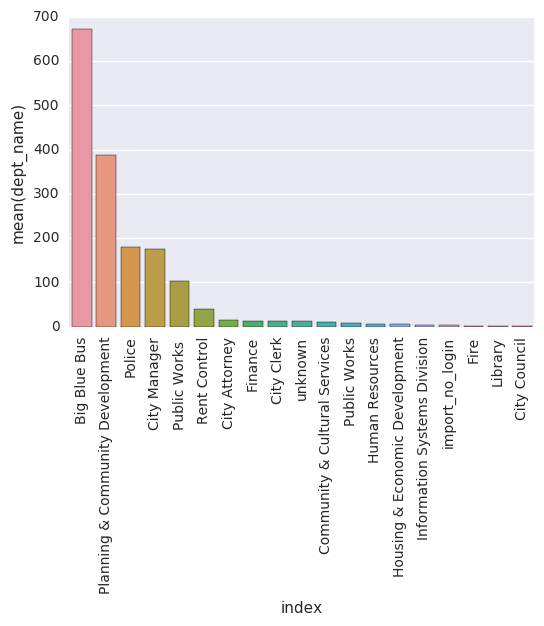

In [66]:
sql = '''
    Select day_to_respond, dept_name, topic 
    from response_day_fact as l inner join department_dim as m
    On l.dept_key = m.dept_key 
    Inner Join service_dim as r
    On l.service_key = r.service_key
    Where day_to_respond > 30;
    '''
df_gt_30 = pd.read_sql(sql, engine)
df_gt_30_by_dept_count = df_gt_30['dept_name'].value_counts().reset_index()
sns.barplot(x='index', y='dept_name', data=df_gt_30_by_dept_count)
plt.xticks(rotation=90)

The top 5 departments, in term of days to close requests, are Big Blue Bus,  Planning & Community Developement, Police, City Manager, and Public Works.

##### Which services took longest times to be closed?

In [67]:
df_days_by_services = df_gt_30[['day_to_respond', 'topic']]

In [68]:
df_days_by_services_avg = df_days_by_services.groupby('topic').mean().sort_values('day_to_respond', ascending=False)
df_days_by_services_avg.columns =['day_to_respond_avg']
pd.set_option('precision',2)
df_days_by_services_avg.head(20)

,day_to_respond_avg
topic,
Section 8 issues,708.50
Employment,432.75
Energy Efficiency,355.00
Council Action Item,350.24
Cable TV,304.00
Other (Refuse and Recycling),255.12
Other (Fire Department),211.00
Sewer Issues,202.00
Other (Water),200.67


It seems that most services requests that took longest time to be closed are long-term public work projects and law and regulation enforcement. 

### Guiding Question 2
Many requests are handled by mulitple departments. If we look at those requests which were closed less than 30 days, is there efficency gain if we streamline request handling process.

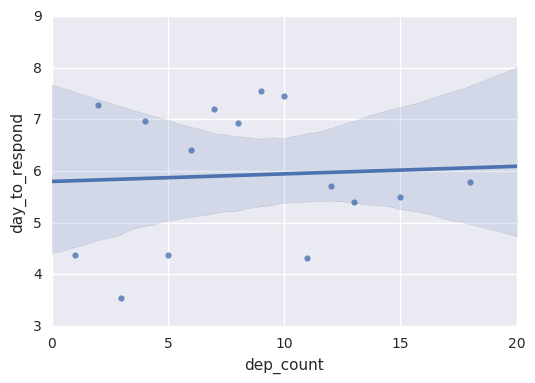

In [69]:
sql = '''
Select day_to_respond, dep_count 
From response_day_fact as l inner join service_dim as r 
On l.service_key = r.service_key
where day_to_respond < 30;
''';
df_day_by_dept_count = pd.read_sql(sql, engine)
#Calculate average of each count group
df_day_by_dept_avg = df_day_by_dept_count.groupby('dep_count').mean().reset_index()
## Is there a relationship?
sns.regplot('dep_count', 'day_to_respond', data=df_day_by_dept_avg)

#### it seems there is a  slightly postive relativeship between days to respond and numbers of departments handling the requests. 

### Guiding Question 3
For those short-term request, is there a seasonal pattern?

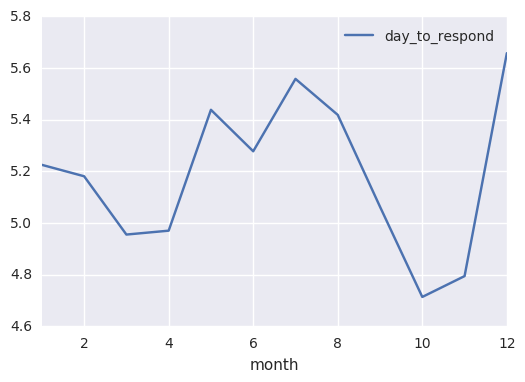

In [70]:
sql = '''
    Select day_to_respond, month
    From response_day_fact as l inner join date_dim as r 
    On l.request_date_key = r.date_key
    Where day_to_respond < 30;
'''
df_month = pd.read_sql(sql, engine)
df_month_avg = df_month.groupby('month').mean().plot()

The graph shows that it took longer to serve those short-term request during summer vacation months and year end.
The government may consider hiring tempoary workers during those time periods in order to bring down the total time taken to process the requests. Also, October seems to exhibit the shortest processing time of all the months so it may be worthwhile to explore the factors that contributed to such efficiency.

### Guiding Question 4
What are some locations that we should avoid?


###### We first pull all the requests that were routed to and/or processed by the police department. From the output we select topics that were of more serious nature versus relatively minor requests such as noise control. From there we mapped the occurences of said serious requests on the map and got a visual of the actual locations. As shown in the map, along the water and mid-city and around the business park are areas where such incidents/request congregate.

In [71]:
%%sql
Select distinct(topic)
From department_dim as l 
    Inner Join response_day_fact as m
    On l.dept_key = m.dept_key
    Inner Join service_dim as r 
    On m.service_key = r.service_key
Where dept_name='Police';



74 rows affected.


topic
Pedestrian Safety
Parks and Beach Use
Bike Licenses
Street Signs & Markings
Leafblowers
Public Records Request
Disturbing the Peace
General Customer Service
Other (Zoning)
Parking Citations - Contesting


In [72]:
sql = '''
Select latitude, longitude
From location_dim as l 
    Inner Join response_day_fact as m
    On l.location_key = m.location_key 
    Inner Join service_dim as r 
    On m.service_key = r.service_key
Where (topic='Gang Activity & Graffiti' 
      or topic='Investigations & Detectives' 
      or topic='Drugs/Narcotics' 
      or topic='Graffiti - private property'
      or topic='Illegal Operations'
      ) 
      And 
      (location <>'unknown');
'''

In [73]:
df_crime = pd.read_sql(sql, engine)
gmap = gmplot.GoogleMapPlotter.from_geocode("Santa Monica")
gmap.scatter(df_crime.latitude.values,df_crime.longitude.values, '#3B0B39', size=60, marker=False)
# The below function created a html file with embeded Google Map API.
# We cannot display the file using Iptyhon IFrame becuause API limitation
# But we can download the html and open it in your browser.
# Here a snapshot of the map is displayed instead
gmap.draw("map.html")

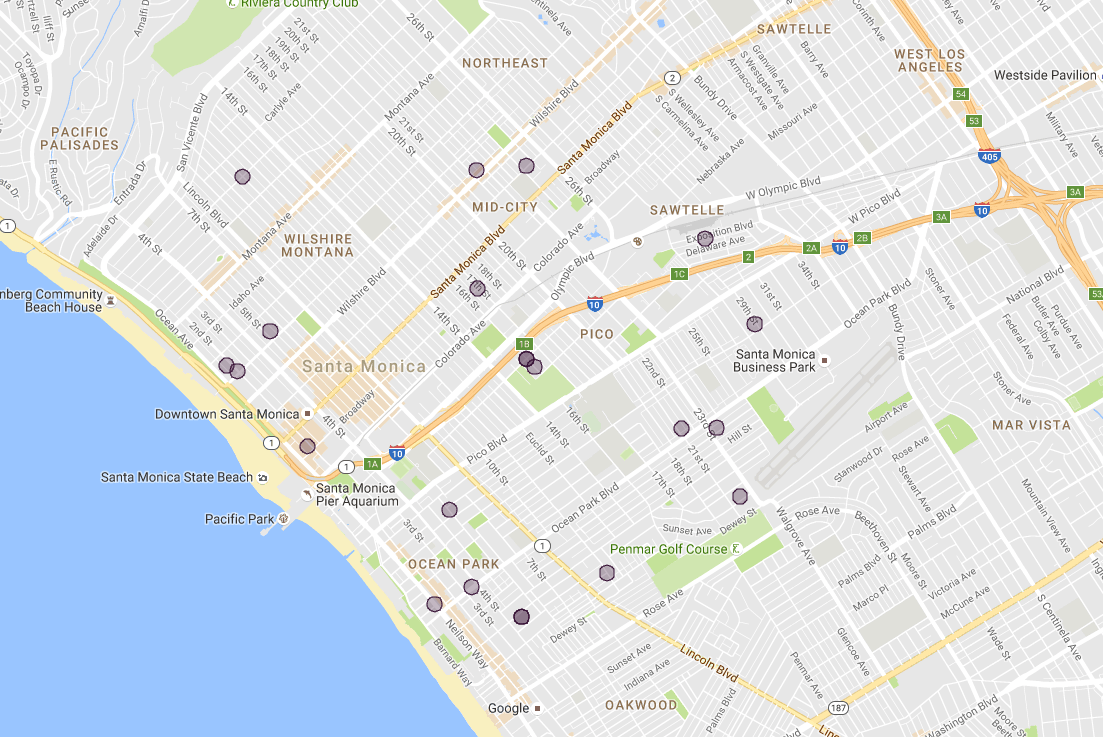

In [74]:
Image('crime.png')

## Bonus (10 points for one of A or B)


### Option A - Automating ETL

Consider the work you did to load your original raw dataset and then transform it into a dimensional model for analysis.  What would it take to automate this process?  How often would you need to update the data?  Could you easily automate any data cleaning steps?  What checks would you need to put in place to ensure quality?  Would humans need to be involved, or could you automate it all?

Discuss.


### Option B - Augmenting dimensions

Considering your dimensional model, what external data could you find to augment it?  As in the case of bike trips, where weather might provide an interesting added dimension/context not present in the original data, you can probably find another source of data to complement your own model.  Identify one such source and add it to your model, demonstrating its value with a few new queries.

### Option A

##### It seems logical to assume that this dataset is updated daily. We can run a daily cron job to download the csv and check the files to see if the name, format, and the number of columns have changed. If yes, the job should stop and send an error message. Otherwise we can check the "Request Date" column. We can take only the previous business day's records. For those new records, we can start by retrieving distinct values of departments, serivice topics, and locations to see if those values exists in those dimensional tables. If they don't, we will follow the above process to create new dimensional keys and insert them into those dimesnional tables. We will then join those new keys with those new records to start generating fact records. Lastly, for the date dimension, we can expand it to multiple years so that we do not have to worry about to update it every time. The above steps can be automated by a python file.  